In [1]:
import os
os.chdir('../src')

from molecular_cloud_initialization import *
from plotters import *
from cluster_cloud_initialization import *


import numpy as np
import matplotlib.pyplot as plt
from amuse.community.fi.interface import Fi
from amuse.lab import Particles, nbody_system
from amuse.couple import bridge
from amuse.units import units
from amuse.community.bhtree.interface import Bhtree
from amuse.ext.sink import new_sink_particles

In [27]:
tot_cloud_mass = 4/3 *units.constants.pi * (15 | units.pc)**3 * ( 2.3 | units.amu * 10 / (units.cm**3))
print(tot_cloud_mass.value_in(units.MSun))

#Assmuing a pure molecular hydrogen cloud, with typical density around 85 molecules per cm^-3, calculate the approximate cloud mass based on
#cloud size. 50 pc is selected for a small GC of only 100 stars. 

7975.78734729


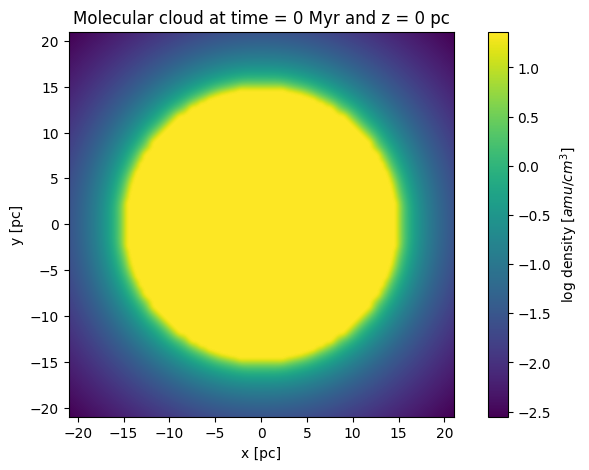

ready for evolution
Time 0.2 Myr
Time 0.4 Myr
Time 0.6 Myr
Time 0.8 Myr
Time 1.0 Myr
Time 1.2 Myr
Time 1.4 Myr
Time 1.6 Myr
Time 1.8 Myr
Time 2.0 Myr


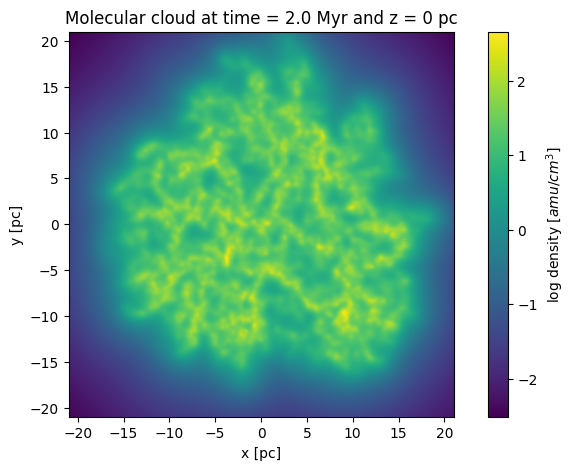

Average mass of a SPH particle 0.026608836794699272.
Mean density of the moelcular cloud 7.91331322863e-20 m**-3 * kg


In [3]:
# initialise and evolve the MC particle set
particles_cloud, converter_cloud  = make_molecular_cloud(N_cloud = 300_000,
                                                         M_cloud = 8_000 | units.MSun,
                                                         R_cloud = 15 | units.pc,
                                                         seed = 1312)

particles_cloud, density_map = evolve_molecular_cloud(particles_cloud, 
                                                    converter_cloud, 
                                                    t_end = 2 | units.Myr, 
                                                    dt = 0.2 | units.Myr, 
                                                    seed = 1312)

print("Mean density of the moelcular cloud", np.mean(particles_cloud.density))

cluster generated


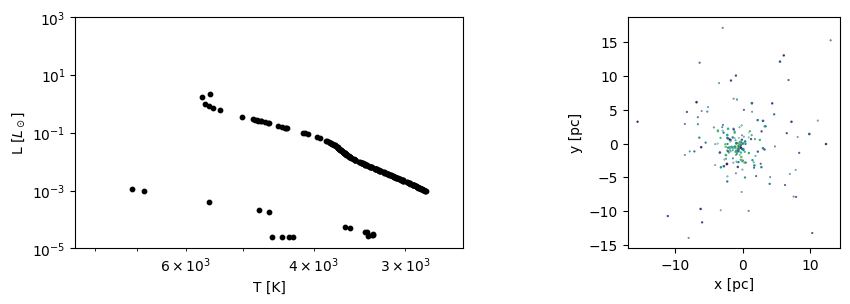

1.02097284569 MSun


In [8]:
star_cluster = make_globular_cluster(star_count = 200,
                                    imf = "kroupa", 
                                    radius = 4 | units.pc,
                                    metallicity = 0.002, 
                                    age = 10 | units.Gyr, 
                                    seed = 2804)

star_cluster.position +=  (-1.0, 0, 0) * (30 | units.pc)
star_cluster.velocity += (1.0, 0, 0) * (40| units.kms)

converter_cluster = nbody_system.nbody_to_si(star_cluster.mass.sum(), 
                                   star_cluster.position.sum())

initial_mass_cluster = np.copy(star_cluster.mass)
print(max(initial_mass_cluster))

In [9]:
def hydro_code(Code, dt, converter, particles, seed):
    '''
    This function contains the parameters we want to initialise the 
    hydro code with. (hard Coded)
    '''
    
    np.random.seed(seed)

    hydro = Code(converter)
    hydro.parameters.use_hydro_flag = True # Hydrodynamics flag. True means:
                            # SPH hydro included, False means: gravity only.
    hydro.parameters.gamma = 1 # gas polytropic index (1.6666667)
                        # (default value:1.6666667). In this case-> Ideal Gas   
    hydro.parameters.timestep = dt
    hydro.parameters.eps_is_h_flag = True # Default value
    hydro.parameters.radiation_flag = False # turns off radiatiative cooling/heat.
    hydro.parameters.isothermal_flag = True  # Isothermal flag. True means:
                                            # isothermal gas (requires integrate_entropy_flag == False)
    hydro.parameters.integrate_entropy_flag = False #True means: integrate
                                                     # entropy, else: internal energy. 
    hydro.gas_particles.add_particles(particles) # add the particles
   
    return hydro    

In [10]:
#initiate the gravity code with sink particles
gravity_code = Bhtree(converter_cluster)
sinks = new_sink_particles(star_cluster)

gravity_code.particles.add_particles(sinks)

In [11]:
# #start the hydro code for the gas
hydro_cloud = hydro_code(Code = Fi, dt = 0.1 | units.Myr,
                         converter = converter_cloud,
                         particles = particles_cloud,
                         seed = 1312)


channel = {"to_sinks": gravity_code.particles.new_channel_to(sinks),
            "from_sinks": sinks.new_channel_to(gravity_code.particles),
            "to_cloud": hydro_cloud.gas_particles.new_channel_to(particles_cloud),
            "from_cloud": particles_cloud.new_channel_to(hydro_cloud.gas_particles)}

In [12]:
gravhydrobridge = bridge.Bridge(use_threading = False)
gravhydrobridge.add_system(gravity_code, (hydro_cloud,) )
gravhydrobridge.add_system(hydro_cloud, (gravity_code,) )
gravhydrobridge.timestep = 0.1 | units.Myr

In [13]:
def bondi_radius(stellar_mass):
    sound_speed = 0.2 | units.kms
    R = 2 * units.constants.G * stellar_mass /(sound_speed **2)

    return R

def bondi_accretion_rate(rho,v,r):
    dM = units.constants.pi * (r**2) * rho * v

    return dM

In [14]:
print(max(initial_mass_cluster))

1.02097284569 MSun


In [15]:
bondi_r = (bondi_radius(1 | units.MSun)).in_(units.pc)

cloud_density = np.mean(particles_cloud.density)
print(bondi_accretion_rate(cloud_density, 40 | units.kms, bondi_r).in_(units.MSun/units.Myr))

6.95070857401 MSun / Myr


In [16]:
print(len(particles_cloud.mass))

300652


Largest sink radius 0.219611656536 parsec
Pre accretion cluster mass 68.9282687749 MSun
Sinks in progress at 0.1  Myr.
Post accretion cluster mass 68.9282687749 MSun
300652 number of cloud particles now


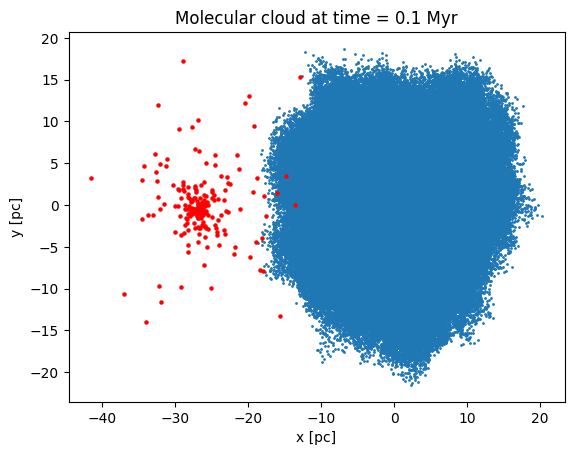

Largest sink radius 0.219611656536 parsec
Pre accretion cluster mass 68.9282687749 MSun
Sinks in progress at 0.2  Myr.
Post accretion cluster mass 68.9282687749 MSun
300652 number of cloud particles now


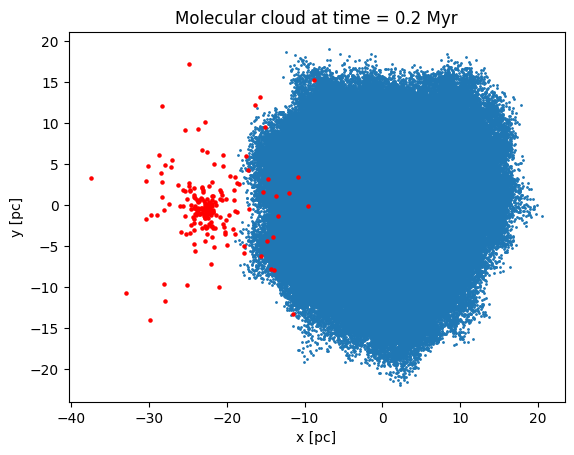

Largest sink radius 0.219611656536 parsec
Pre accretion cluster mass 68.9282687749 MSun
Sinks in progress at 0.3  Myr.
Post accretion cluster mass 68.9548776117 MSun
300651 number of cloud particles now


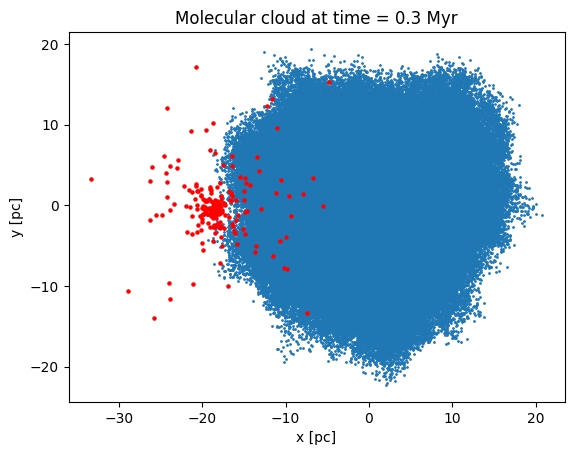

Largest sink radius 0.219611656536 parsec
Pre accretion cluster mass 68.9548776117 MSun
Sinks in progress at 0.4  Myr.
Post accretion cluster mass 69.30079249 MSun
300638 number of cloud particles now


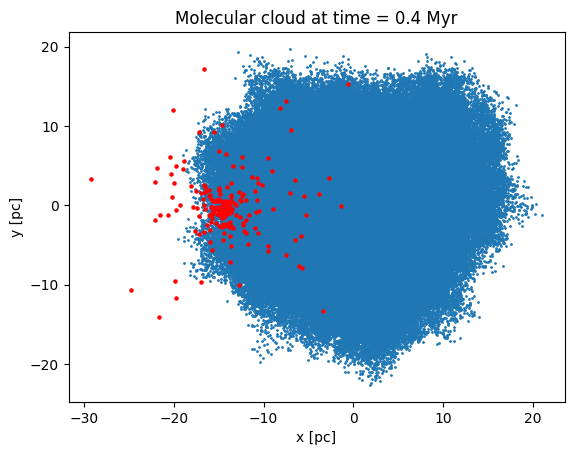

Largest sink radius 0.220813295395 parsec
Pre accretion cluster mass 69.30079249 MSun
Sinks in progress at 0.5  Myr.
Post accretion cluster mass 69.9660134099 MSun
300613 number of cloud particles now


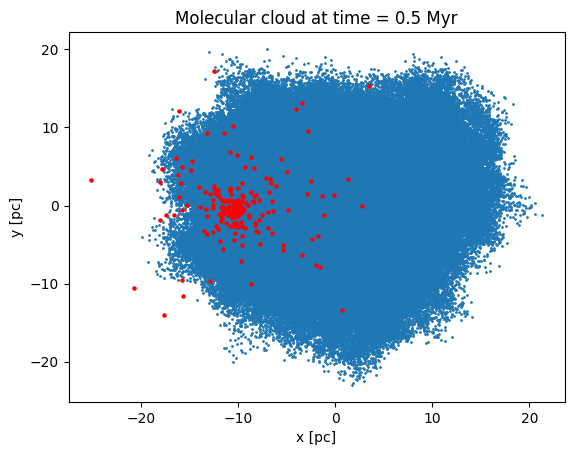

Largest sink radius 0.2322604377 parsec
Pre accretion cluster mass 69.9660134099 MSun
Sinks in progress at 0.6  Myr.
Post accretion cluster mass 70.338537125 MSun
300599 number of cloud particles now


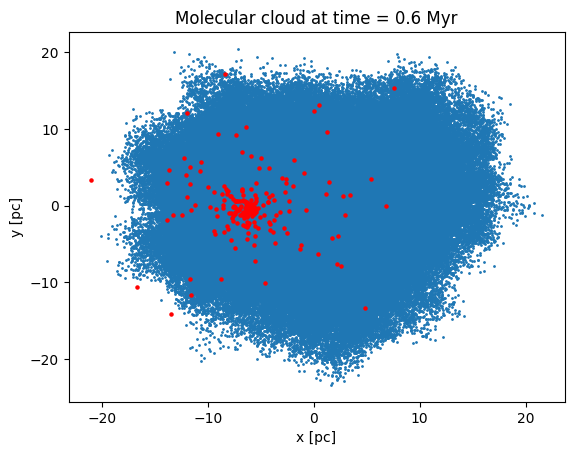

Largest sink radius 0.2322604377 parsec
Pre accretion cluster mass 70.338537125 MSun
Sinks in progress at 0.7  Myr.
Post accretion cluster mass 71.2166287392 MSun
300566 number of cloud particles now


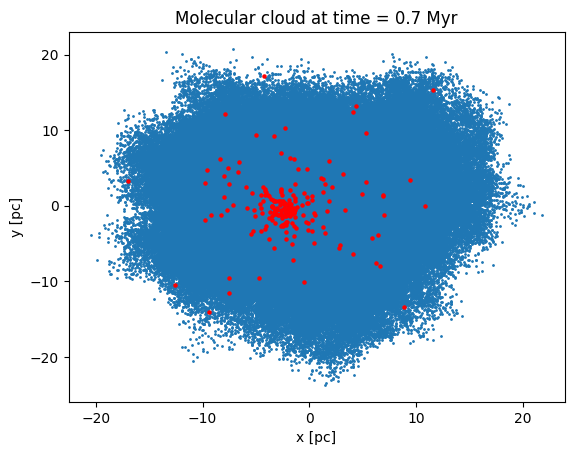

Largest sink radius 0.249431151157 parsec
Pre accretion cluster mass 71.2166287392 MSun
Sinks in progress at 0.8  Myr.
Post accretion cluster mass 71.8552408223 MSun
300542 number of cloud particles now


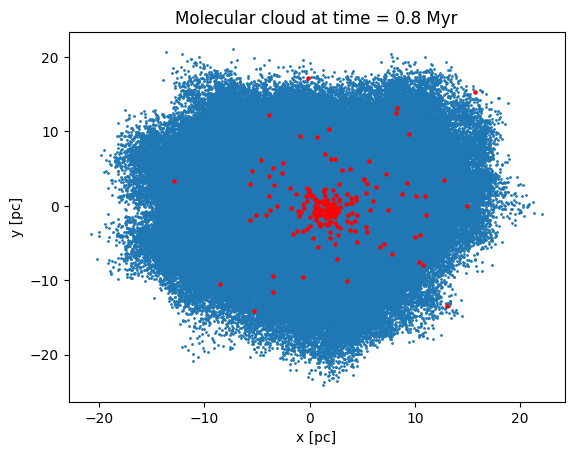

Largest sink radius 0.260878293462 parsec
Pre accretion cluster mass 71.8552408223 MSun
Sinks in progress at 0.9  Myr.
Post accretion cluster mass 72.6268970893 MSun
300513 number of cloud particles now


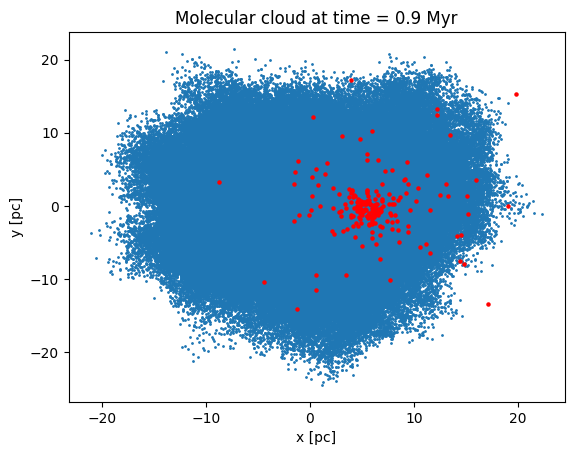

Largest sink radius 0.283772578072 parsec
Pre accretion cluster mass 72.6268970893 MSun
Sinks in progress at 1.0  Myr.
Post accretion cluster mass 73.3719445196 MSun
300485 number of cloud particles now


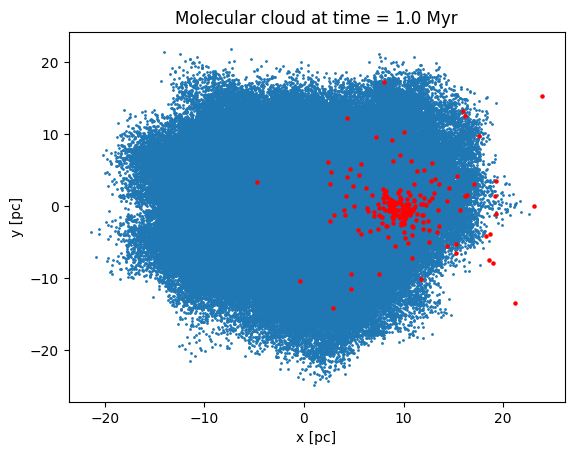

Largest sink radius 0.283772578072 parsec
Pre accretion cluster mass 73.3719445196 MSun
Sinks in progress at 1.1  Myr.
Post accretion cluster mass 73.8775124187 MSun
300466 number of cloud particles now


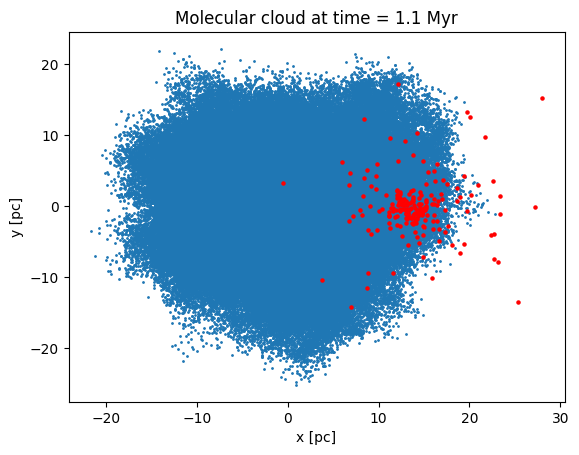

Largest sink radius 0.283772578072 parsec
Pre accretion cluster mass 73.8775124187 MSun
Sinks in progress at 1.2  Myr.
Post accretion cluster mass 74.090383113 MSun
300458 number of cloud particles now


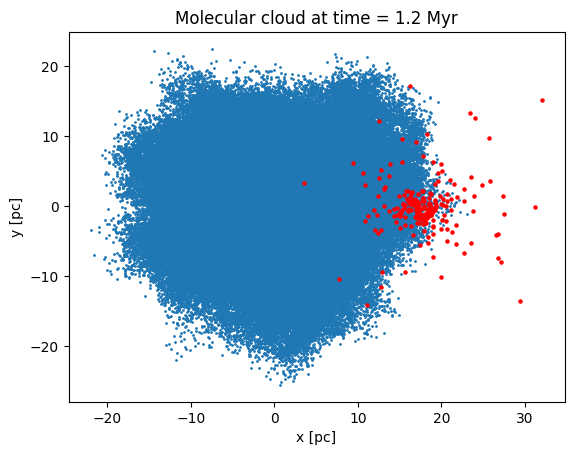

Largest sink radius 0.283772578072 parsec
Pre accretion cluster mass 74.090383113 MSun
Sinks in progress at 1.3  Myr.
Post accretion cluster mass 74.1436007866 MSun
300456 number of cloud particles now


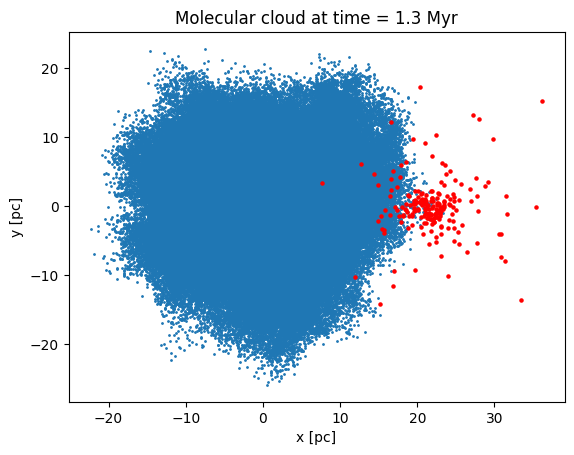

Largest sink radius 0.283772578072 parsec
Pre accretion cluster mass 74.1436007866 MSun
Sinks in progress at 1.4  Myr.
Post accretion cluster mass 74.1436007866 MSun
300456 number of cloud particles now


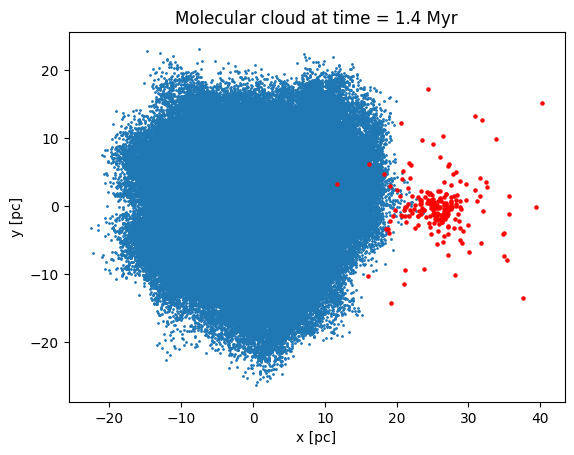

Largest sink radius 0.283772578072 parsec
Pre accretion cluster mass 74.1436007866 MSun
Sinks in progress at 1.5  Myr.
Post accretion cluster mass 74.1436007866 MSun
300456 number of cloud particles now


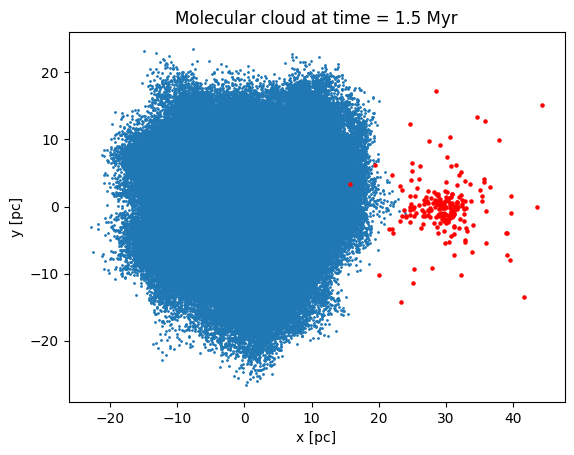

Largest sink radius 0.283772578072 parsec
Pre accretion cluster mass 74.1436007866 MSun
Sinks in progress at 1.6  Myr.
Post accretion cluster mass 74.1436007866 MSun
300456 number of cloud particles now


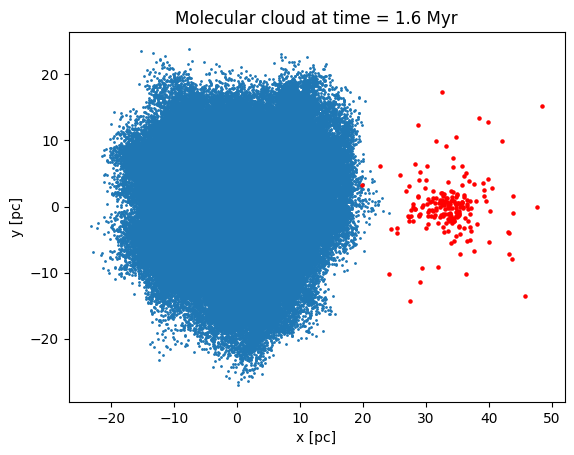

Largest sink radius 0.283772578072 parsec
Pre accretion cluster mass 74.1436007866 MSun
Sinks in progress at 1.7  Myr.
Post accretion cluster mass 74.1436007866 MSun
300456 number of cloud particles now


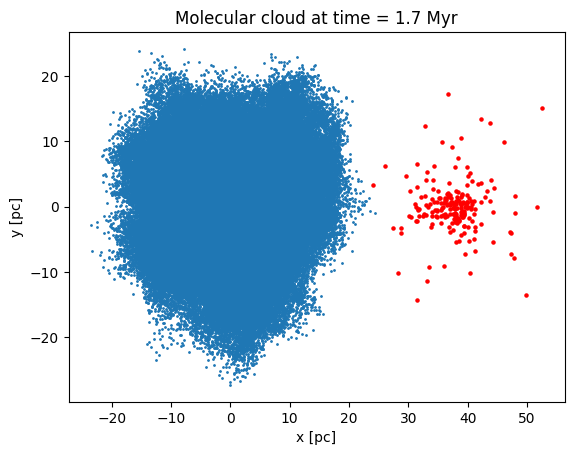

Largest sink radius 0.283772578072 parsec
Pre accretion cluster mass 74.1436007866 MSun
Sinks in progress at 1.8  Myr.
Post accretion cluster mass 74.1436007866 MSun
300456 number of cloud particles now


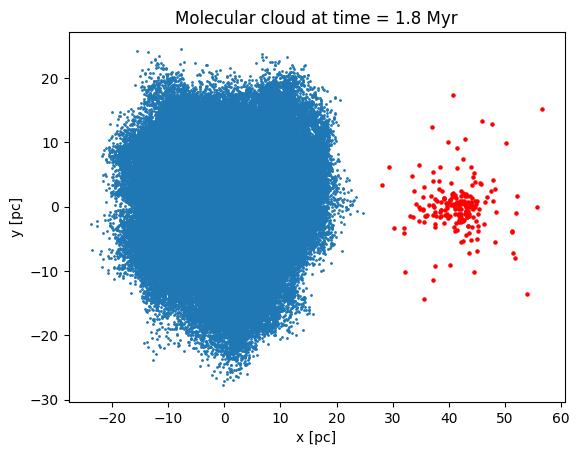

Largest sink radius 0.283772578072 parsec
Pre accretion cluster mass 74.1436007866 MSun
Sinks in progress at 1.9  Myr.
Post accretion cluster mass 74.1436007866 MSun
300456 number of cloud particles now


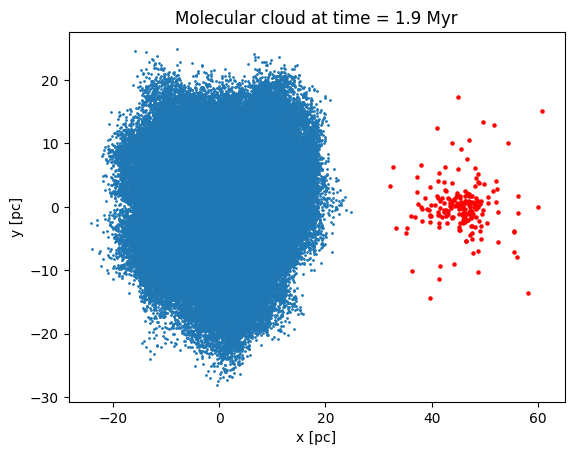

Largest sink radius 0.283772578072 parsec
Pre accretion cluster mass 74.1436007866 MSun
Sinks in progress at 2.0  Myr.
Post accretion cluster mass 74.1436007866 MSun
300456 number of cloud particles now


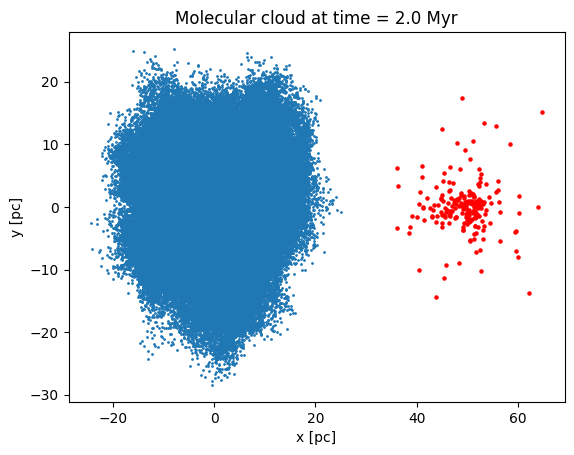

In [17]:
t_end = 2 | units.Myr
model_time = 0 | units.Myr
dt = 0.1 | units.Myr

# L = int(abs(sinks.position.sum().value_in(units.pc)))*1.2
# N = 500

sinks_mass_snapshots = []

while model_time < t_end:
    
    # define the accreting radius of the sinks particle based on its Bondi radius
    # IMPORTANT: the mass changes after each accretion event
    sinks.sink_radius = bondi_radius(sinks.mass).in_(units.pc)

    print("Largest sink radius", max(sinks.sink_radius).in_(units.pc))

    print("Pre accretion cluster mass", sinks.mass.sum())
    
    model_time += dt
    model_time = model_time.round(1)
    # evolve the gravity and hydro codes through our bridge
    gravhydrobridge.evolve_model(model_time)


    # update channels (copy over from the codes.particles to the particle sets)
    channel["to_sinks"].copy()
    channel["to_cloud"].copy()

    print("Sinks in progress at", model_time.value_in(units.Myr), " Myr.")
    # add the acretted mass to the sinks's total mass
    sinks.accrete(particles_cloud)

    # update channels (copy the information from the particle set to the gravity code)
    channel["from_sinks"].copy()
    channel["from_cloud"].copy()

    # save the total mass of each step
    sinks_mass_snapshots.append(sinks.mass.value_in(units.MSun))

    print("Post accretion cluster mass", sinks.mass.sum())
    print(len(particles_cloud.mass), "number of cloud particles now")

    plt.scatter(particles_cloud.x.value_in(units.pc), particles_cloud.y.value_in(units.pc), s = 1)
    plt.scatter(sinks.x.value_in(units.pc), sinks.y.value_in(units.pc), c = 'red', s = 5)
    plt.title("Molecular cloud at time = " + model_time.as_string_in(units.Myr))
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    plt.show()


In [18]:
mass_difference = sinks_mass_snapshots[-1] - sinks_mass_snapshots[0]
mass_difference

array([  2.66088368e-02,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   7.98265104e-02,
         2.66088368e-02,   0.00000000e+00,   2.77555756e-17,
         0.00000000e+00,   0.00000000e+00,   2.66088368e-02,
         5.55111512e-17,   2.77555756e-17,   3.19306042e-01,
         2.66088368e-02,   2.66088368e-02,   1.33044184e-01,
         1.59653021e-01,   5.32176736e-02,   0.00000000e+00,
         0.00000000e+00,   1.38777878e-17,   2.66088368e-02,
         2.66088368e-02,   3.45914878e-01,   0.00000000e+00,
         0.00000000e+00,   2.77555756e-17,   2.77555756e-17,
         7.98265104e-02,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   2.66088368e-02,   0.00000000e+00,
         0.00000000e+00,   1.59653021e-01,   2.22044605e-16,
         2.66088368e-02,   2.66088368e-02,   0.00000000e+00,
         7.98265104e-02,   0.00000000e+00,   8.32667268e-17,
         0.00000000e+00,   1.38777878e-17,   5.32176736e-02,
         1.38777878e-17,

In [32]:
len(relevant_masses)

22

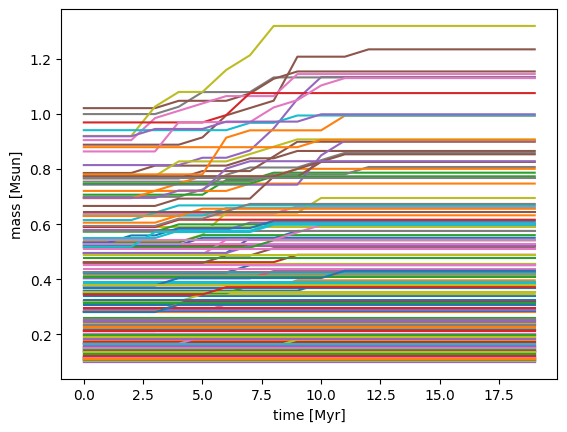

In [19]:
plt.plot(sinks_mass_snapshots)
plt.xlabel("time [Myr]")
plt.ylabel("mass [Msun]")
plt.show()

(array([ 136.,   14.,   18.,    0.,    6.,    2.,    6.,    2.,    1.,
           2.,    3.,    0.,    4.,    0.,    0.,    0.,    1.,    0.,
           1.,    0.,    1.,    0.,    0.,    1.,    0.,    1.,    0.,
           0.,    0.,    1.]),
 array([ 0.        ,  0.01330442,  0.02660884,  0.03991326,  0.05321767,
         0.06652209,  0.07982651,  0.09313093,  0.10643535,  0.11973977,
         0.13304418,  0.1463486 ,  0.15965302,  0.17295744,  0.18626186,
         0.19956628,  0.21287069,  0.22617511,  0.23947953,  0.25278395,
         0.26608837,  0.27939279,  0.2926972 ,  0.30600162,  0.31930604,
         0.33261046,  0.34591488,  0.3592193 ,  0.37252372,  0.38582813,
         0.39913255]),
 <BarContainer object of 30 artists>)

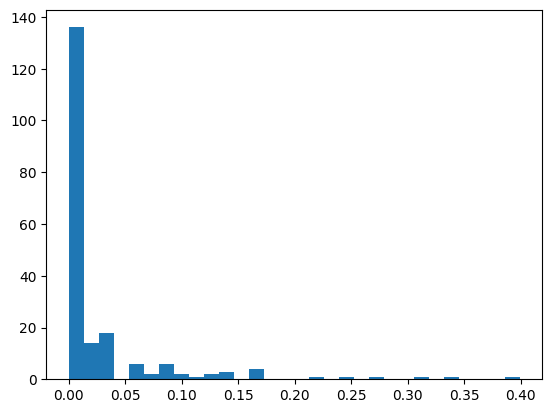

In [20]:
plt.hist(mass_difference, bins  = 30)

In [ ]:
gravity_code.stop()
hydro_cloud.stop()
gravhydrobridge.stop()

In [ ]:
# # initialise the star particle set
# star = Particles(1)
# star.name = "star"
# star.mass = 0.7 |units.MSun
# star.radius = star.mass[0].value_in(units.MSun)**0.8 | units.RSun
# star.position = (-1.0, 0, 0) * (17 | units.pc)
# star.velocity = (1.0, 0, 0) * (20| units.kms)
# inital_mass = np.copy(star.mass)
# converter_star = nbody_system.nbody_to_si(star.mass.sum(), 
#                                    star.position.sum())